# Build a chatbot from scratch

Hello everyone, nowadays, after the release of chatGPT - a natural language AI, the Data Science & AI once again rise. Having been interested in data science for so long, now i see that as an oppotunity for me to learn more about the world of AI and data science. today, i am going to try to build a chatbot from scratch, by doing this way, i have the oppotunity to learn how to build a database, how does training AI look like, what is the process of making an AI.

The data im getting to train my AI is from [Kaggle](https://www.kaggle.com/datasets/elvinagammed/chatbots-intent-recognition-dataset). It's a good data to use to train my chatbot.



## I - Data Preparation

### Import statment

I will first import several libraries that I would be using.

In [ ]:
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import string

I also need to import the data too!

In [ ]:
data = json.load(open('/content/Intent.json'))
data = data["intents"]

If you look closely at the data, it has some important collumns that will be useful for use to build a chatbot.

- `intent`: the intentions of the phrases
- `text`: the texts that are usually associated with that intention. For example, "Hi" is an text usually associates with
- `responses`: the possible responses for this intentions

These 3 collumns with be enugh for us to build a chatbot.

### The data

Now let build a dataframe from pandas

In [ ]:
df = pd.DataFrame(data)
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, please tell me your GeniSys user, H...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is Adam, This is Adam, I am Adam, It ...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you? Please tell m...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Good thanks! My user is Adam, Good thanks! Th...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


## II - Chatbot strategy

To build a chatbot, we need to develop an strategy.

In real life, when we are in a conversation, you listen to the speaker what they says, and process that information by thinking what do they mean and choose the most possible answer to what the sentences they have said earlier.

This is what also going to be implemmented in our chatbot. We will first let the user inputs something, let the AI guess the intentions of the inpunt and Define the various intents (user inputs) and corresponding responses.


### Create necessary Dataframes

I will ccreate 2 dataframes called `df_patterns` which consists of `texts` and `intent` and the other dataframe called `df_responses` which have `responses` and `intents` collumns.

In [ ]:
df_patterns = df[['text', 'intent']]
df_responses = df[['responses', 'intent']]

In [ ]:
df_patterns.head()

,text,intent
0,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...",Greeting
1,"[My user is Adam, This is Adam, I am Adam, It ...",GreetingResponse
2,"[How are you?, Hi how are you?, Hello how are ...",CourtesyGreeting
3,"[Good thanks! My user is Adam, Good thanks! Th...",CourtesyGreetingResponse
4,"[What is my name?, What do you call me?, Who d...",CurrentHumanQuery


In [ ]:
df_responses.head()

,responses,intent
0,"[Hi human, please tell me your GeniSys user, H...",Greeting
1,"[Great! Hi <HUMAN>! How can I help?, Good! Hi ...",GreetingResponse
2,"[Hello, I am great, how are you? Please tell m...",CourtesyGreeting
3,"[Great! Hi <HUMAN>! How can I help?, Good! Hi ...",CourtesyGreetingResponse
4,"[You are <HUMAN>! How can I help?, Your name i...",CurrentHumanQuery


As you can see, the repsonses and the texts are ok for the coresponding intents, but there is one problem is that they are in an array, which we don't want it to happen so we need to explode the array and make each index an individual cell.

In [ ]:
df_patterns = df_patterns.explode('text')
df_responses = df_responses.explode('responses')

df_patterns.head()

,text,intent
0,Hi,Greeting
0,Hi there,Greeting
0,Hola,Greeting
0,Hello,Greeting
0,Hello there,Greeting


In [ ]:
df_patterns['text'] = df_patterns['text'].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation).lower())
df_responses['responses'] = df_responses['responses'].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation).lower())
df_responses.head()

,responses,intent
0,hi human please tell me your genisys user,Greeting
0,hello human please tell me your genisys user,Greeting
0,hola human please tell me your genisys user,Greeting
1,great hi human how can i help,GreetingResponse
1,good hi human how can i help you,GreetingResponse


### The Algorithm

So my approach would be this:


1. We will first train the algorithm to recognize which texts is from which intent, to achieve that, first we must break it the text into separate words and tokenize those words and put then into a sequence for easier computation. THen we will take those tokenized sequences and fit them with the approriate intents.

2. After we trained the model, I would get input from the user, the input well also be tokenized and matched with the right intents, after this, we will use `df_ responses` to randomly choose a response to the user's inputs.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(df_patterns['text'])
sequences = tokenizer.texts_to_sequences(df_patterns['text'])
x_train = pad_sequences(sequences)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df_patterns["intent"])

In this section, the Tokenizer class from Keras is imported. A tokenizer is a tool used to split text into individual words (tokens) and assign unique numerical indices to each word. Here, a tokenizer is initialized with a `num_words` parameter of 2000, which indicates that only the top 2000 most frequent words will be considered. The `fit_on_texts` method is called on the tokenizer, which processes the text data provided in `df_patterns['text']` and learns the vocabulary from it. Next, the `texts_to_sequences` method is used to convert the text into sequences of tokenized indices. These sequences are stored in the sequences variable.

t, the LabelEncoder class from `Scikit-learn` is imported. A label encoder is used to convert categorical labels into numerical representations. Here, a label encoder is initialized as le, and the fit_transform method is called on it, passing `df_patterns["intent"]` as the target labels. This method learns the unique intents from the data and assigns a numerical label to each intent. The encoded labels are stored in the `y_train` variable.

By tokenizing the text data and padding the sequences, we prepare the input (`x_train`) for training the model. The label encoder helps encode the intents into numerical representations (`y_train`) suitable for model training and evaluation.

In [ ]:
input_shape = x_train.shape[1]
print(input_shape)

9



In the first line, `x_train.shape[1]` retrieves the second dimension of the `x_train` array, which corresponds to the length of the sequences in the input data. The `shape` attribute of a NumPy array returns a tuple indicating the dimensions of the array.

By assigning `x_train.shape[1]` to the `input_shape` variable, we capture the length of the sequences, which is essential information for defining the shape of the input layer in the subsequent model architecture.

The second line, `print(input_shape)`, simply prints the value of `input_shape` to the console, allowing you to verify the calculated value. This step can be useful for debugging or understanding the shape of the input data before building the model.

In [ ]:
#Define vocab
num_vocabulary = len(tokenizer.word_index)
print("number of unique words:", num_vocabulary)
output_length = le.classes_.shape[0]
print("output length:", output_length)

number of unique words: 117
output length: 22



In this section, `len(tokenizer.word_index)` retrieves the number of unique words in the vocabulary that was learned by the tokenizer. The `word_index` attribute of the tokenizer is a dictionary that maps each word to its corresponding index. By calculating the length of this dictionary, we obtain the total number of unique words in the vocabulary. The value is assigned to the variable `num_vocabulary`. The subsequent line prints the number of unique words to the console, providing visibility into the size of the vocabulary.

`le.classes_.shape[0]` retrieves the shape of the encoded intent classes obtained from the label encoder. The `classes_` attribute of the label encoder returns the unique classes (intents) in the encoded form. The shape of this array is then accessed to obtain the length of the classes. The value is assigned to the variable `output_length`. The subsequent line prints the output length to the console, giving you information about the number of unique intents present in the dataset.

By determining the vocabulary size (`num_vocabulary`) and the output length (`output_length`), these values can be utilized in further steps of the model architecture, such as defining the dimensions of the embedding layer and the output layer.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense
from tensorflow.keras.models  import Model


i = Input(shape =(input_shape))
x = Embedding(num_vocabulary+1, 10)(i)
x = LSTM(10, return_sequences = True)(x)
x = Flatten()(x)
x = Dense(output_length, activation = "softmax")(x)
model = Model(i, x)

The code snippet you provided defines a Keras model with an input layer, embedding layer, LSTM layer, flatten layer, and dense output layer. Let's break it down:

```python
from tf.keras.layers import Input, Embedding, LSTM, Flatten, Dense
from tf.keras.models import Model

i = Input(shape=(input_shape))
x = Embedding(num_vocabulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)
```

1. Importing Libraries:
   ```python
   from tf.keras.layers import Input, Embedding, LSTM, Flatten, Dense
   from tf.keras.models import Model
   ```
   This section imports the necessary layers and models from the Keras library to build the model.

2. Input Layer:
   ```python
   i = Input(shape=(input_shape))
   ```
   This line defines an input layer with the shape specified by `input_shape`. The `input_shape` is assumed to have been defined earlier in the code.

3. Embedding Layer:
   ```python
   x = Embedding(num_vocabulary + 1, 10)(i)
   ```
   This line adds an embedding layer to the model. The embedding layer maps the input sequence of word indices to dense vectors of dimension 10. The `num_vocabulary + 1` represents the size of the vocabulary plus one for out-of-vocabulary (OOV) words.

4. LSTM Layer:
   ```python
   x = LSTM(10, return_sequences=True)(x)
   ```
   This line adds an LSTM layer to the model. The LSTM layer has 10 units and is set to return the entire sequence of outputs rather than just the last output.

5. Flatten Layer:
   ```python
   x = Flatten()(x)
   ```
   This line adds a flatten layer to the model. The flatten layer converts the output of the LSTM layer into a 1-dimensional tensor, preparing it for the subsequent dense layer.

6. Dense Layer:
   ```python
   x = Dense(output_length, activation="softmax")(x)
   ```
   This line adds a dense layer to the model. The dense layer has `output_length` units, which corresponds to the number of classes or intents in the output. The activation function used is softmax, which produces a probability distribution over the output classes.

7. Model Compilation:
   ```python
   model = Model(i, x)
   ```
   This line creates a Keras model using the input layer `i` and output layer `x`. The resulting model can be compiled, trained, and evaluated for intent recognition tasks.

In summary, the code defines a sequential model architecture with an embedding layer to represent the input sequence, an LSTM layer to capture sequential patterns, and a dense output layer to predict the intent based on the learned features.

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

The code snippet you provided compiles the Keras model with specific loss, optimizer, and metrics configurations. Let's break it down:

```python
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
```

- Loss Function:
   ```python
   loss = "sparse_categorical_crossentropy"
   ```
   This line sets the loss function for the model. In this case, it uses the "sparse_categorical_crossentropy" loss function. This loss function is suitable for multi-class classification tasks where the target variable (intents in this case) is encoded as integers.

- Optimizer:
   ```python
   optimizer = "adam"
   ```
   This line specifies the optimizer to be used during the model training. The "adam" optimizer is a popular optimization algorithm that adapts the learning rate dynamically based on the characteristics of the training data. It is well-suited for a wide range of deep learning tasks.

- Metrics:
   ```python
   metrics = ["accuracy"]
   ```
   This line sets the evaluation metric(s) to be used during training and evaluation. In this case, the model will be evaluated based on accuracy, which measures the fraction of correctly predicted intents.

By compiling the model with the specified loss function, optimizer, and metrics, it is ready to be trained and evaluated using the provided configurations. The choice of loss function, optimizer, and metrics depends on the specific requirements of the intent recognition task and can be modified to suit different scenarios.

In [ ]:
train = model.fit(x_train, y_train, epochs = 200)

Epoch 1/200
5/5 [==============================] - 6s 18ms/step - loss: 3.0921 - accuracy: 0.0420
Epoch 2/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0886 - accuracy: 0.1049
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 3.0855 - accuracy: 0.1329
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 3.0824 - accuracy: 0.2168
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 3.0788 - accuracy: 0.2238
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 3.0749 - accuracy: 0.2657
Epoch 7/200
5/5 [==============================] - 0s 16ms/step - loss: 3.0700 - accuracy: 0.2727
Epoch 8/200
5/5 [==============================] - 0s 17ms/step - loss: 3.0644 - accuracy: 0.2867
Epoch 9/200
5/5 [==============================] - 0s 21ms/step - loss: 3.0576 - accuracy: 0.2657
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 3.0497 - accuracy: 0.2797
Epoch 11/200
5/5 [=

The `fit()` function is a method in Keras that trains the model on the provided data. It iterates over the dataset for the specified number of epochs, adjusting the model's internal parameters to minimize the specified loss function and improve performance. During each epoch, the model makes predictions, calculates the loss, and updates its parameters using the optimization algorithm specified during compilation.

In this case, the model will be trained for 200 epochs, meaning it will go through the entire dataset 200 times. This allows the model to learn from the data and improve its performance over time.

## III - The result

Now let's see the result

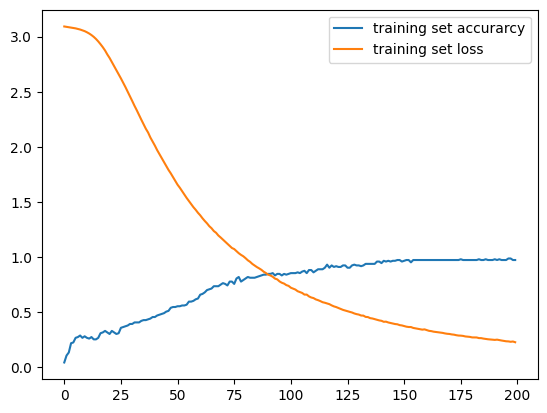

In [ ]:
plt.plot(train.history["accuracy"], label = "training set accurarcy")
plt.plot(train.history["loss"], label = "training set loss")
plt.legend()

According to the graph, the accuary of the model gradually achieves 100% as more training we do, while the loss exponentially decreases.

### IV - The chatbot

1. Setting up an Infinite Loop: The code starts with a `while True` loop, which creates an infinite loop that continues until a certain condition is met.

2. User Input: The user is prompted to enter their input with the `input("You: ")` line. The input is stored in the `prediction_input` variable.

3. Preprocessing the User Input: The user input is preprocessed by converting all characters to lowercase and removing any punctuation using a list comprehension.

4. Tokenization and Padding: The preprocessed input is tokenized using the `tokenizer.texts_to_sequences()` function to convert it into a sequence of word indices. Then, the input sequence is padded using `pad_sequences()` to ensure it has the same length as the `input_shape` defined earlier.

5. Making a Prediction: The preprocessed and padded input is passed to the model's `predict()` function to obtain the model's output, which represents the predicted intent or category.

6. Mapping the Output to a Response: The predicted output is mapped back to its corresponding intent label using the `inverse_transform()` function of the label encoder (`le`). The resulting intent is stored in the `response_tag` variable.

7. Generating a Random Response: A random response is chosen from a dataframe (`df_responses`) based on the predicted intent. The response is printed as the AI's reply.

8. Exiting the Loop: If the predicted intent is "GoodBye", indicating the user wants to end the conversation, the loop is terminated with the `break` statement.

In [ ]:

while True:
    text_p = []
    prediction_input = input("You: ")

    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    text_p.append(prediction_input)

    prediction_input = tokenizer.texts_to_sequences(text_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], maxlen=input_shape)


    output = model.predict(prediction_input)
    output = output.argmax()

    response_tag = le.inverse_transform([output])[0]
    print("AI:", random.choice(df_responses[df_responses["intent"] == response_tag]["responses"].values))

    if response_tag == "GoodBye":
        break


You: hello
1/1 [==============================] - 0s 485ms/step
AI: hola human please tell me your genisys user
You: how are you
1/1 [==============================] - 0s 21ms/step
AI: hello how are you i am great thanks please tell me your genisys user
You: tell me a story
1/1 [==============================] - 0s 21ms/step
AI: system says no
You: what is that
1/1 [==============================] - 0s 31ms/step
AI: its life jim but not as we know it
You: can you show me the way?
1/1 [==============================] - 0s 23ms/step
AI: they call you human what can i do for you
You: goodbye
1/1 [==============================] - 0s 24ms/step
AI: bye come back again soon


Yay so we just built our chatbot from scratch! Not too hard eh? :)